<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/10.16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Model Based Reinforcement Learning
In this lab, we will star practicing about Gaussian Process and then we will apply it to Model Based RL (MBRL).

## Exercise 1: Intro to Gaussian Processes with GPyTorch

***Objective:*** Build intuition for Gaussian Processes (GPs) by:
- Fitting an **exact GP** to noisy 1D data
- Visualizing **posterior mean + uncertainty**
- Understanding the effects of **noise** and **lengthscale**
- Exploring **extrapolation** (add a linear mean)
- Trying a **sparse GP** with inducing points (optional)

For more information. Check the GP Tutorial: https://docs.gpytorch.ai/en/v1.6.0/examples/01_Exact_GPs/Simple_GP_Regression.html

---

### Data
Use a 1D function with noise:
- f(x) = sin(2πx) + 0.3 * sin(6πx) + 3
- x ∈ [-1.0, 1.0]
- Add Gaussian noise σ_n (try 0.05 and 0.2)

---

## Tasks

### Part A — Exact GP regression (RBF kernel)
1. Implement an **ExactGP** model in GPyTorch:
   - Mean: `ZeroMean`
   - Covariance: `ScaleKernel(RBFKernel)`
   - Likelihood: `GaussianLikelihood`
2. Train by **maximizing log marginal likelihood** (Adam).
3. Plot:
   - Training points
   - Posterior mean
   - 95% confidence band

### Part B — Hyperparameters & data noise
1. Vary the **noise level** in the data (e.g., 0.05 vs 0.2).
2. For each setting, re-train the GP and report learned:
   - `likelihood.noise` (data noise)
   - `kernel.lengthscale`
3. Discuss how these affect smoothness and the width of uncertainty.

### Part C — Extrapolation behavior
1. **Hold out** the rightmost region (e.g., train on x ∈ [-1, 0.5], test on x ∈ (0.5, 1]).
2. Show how the posterior behaves outside the training region.
3. Add a **linear mean** (or `ConstantMean + LinearMean`) and compare extrapolation.

### Part D — (Graduate level) Sparse GP with inducing points
1. Replace Exact GP with **variational inducing-point GP** (SVGP) using `gpytorch.models.ApproximateGP`.
2. Choose M = 32 or 64 inducing points spread across x.
3. Compare posterior to the exact GP.
4. Plot N (number of samples) Vs training time for SVGP and ExactGP

---

## Deliverables
- Code for Parts A–C (Part D for grad students)
- Plots:
  - Mean ± 2 std band with training data
  - Effect of noise and lengthscale
  - Extrapolation comparison (zero vs linear/constant mean)
- Short write-up (≤1 page, as a cell in the notebook):
  - What did increasing noise do to learned hyperparameters and uncertainty?
  - How does the kernel lengthscale affect fit and confidence?
  - Why does the GP behave the way it does when extrapolating? How did the mean function change that?
  - (Grad level) Sparse vs Exact: trade-offs you observed

---

## Hints
- Normalize tensors to `float32` and move to GPU if available.
- Use `model.train(); likelihood.train()` for training, and `.eval()` for evaluation.
- For plotting uncertainty: `lower, upper = pred.confidence_region()`.
- Clip very small noise/lengthscale during early training if it becomes unstable.
- For SVGP, look at: `gpytorch.variational`, `gpytorch.mlls.VariationalELBO`.



The larger the observation noise, the greater the uncertainty, and the wider the confidence intervals (95% CIs).Moreover, when the observation noise is smaller, the Gaussian Process tends to overfit individual samples more easily. If the lengthscale is learnable, it will increase to prevent overfitting in this case.


The lengthscale determines how quickly correlations decay with input distance.A larger lengthscale tends to cause underfitting, while a smaller one tends to cause overfitting. The uncertainty reflects this: a small lengthscale reduces local variance (since each sample point only influences its nearby region), whereas a large lengthscale affects a much broader area.


In the extrapolating region where no data are available, the posterior reverts to its prior mean. A ConstantMean GP prediction will revert to a constant value, with uncertainty increasing rapidly as the distance grows, while a LinearMean will follow a linear function.


The exact Gaussian Process has a training complexity of O(N3)and a prediction complexity of O(N2), making the computation very expensive when N is large. The Sparse Variational Gaussian Process (SVGP) introduces M inducing points, reducing the cost to roughly O(NM2). When N is particularly large (2560 in the experiment), SVGP is much faster than GP because its computational cost increases linearly with N, rather than cubically; however, this approximation reduces accuracy in densely sampled regions.



In [ ]:
## Install required libraries
!pip -q install gpytorch torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.4 MB/s eta 0:00:00


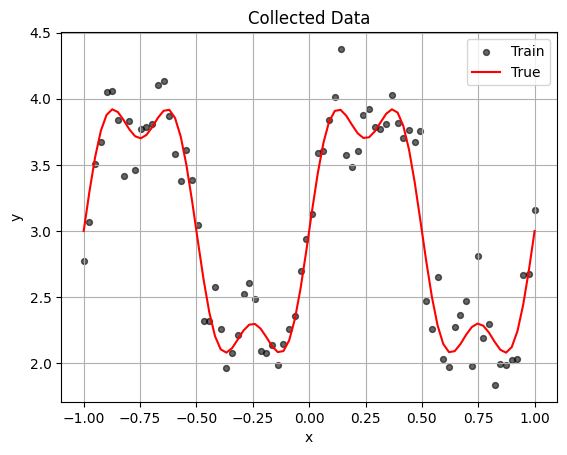

In [ ]:
# =======================
# Collecting DATA
# =======================
import torch, math
import gpytorch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Parameter for data generator
NOISE_STD = 0.2
N = 80

def f(x):
  return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3


# ---------- Data ----------
def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std*torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True)
plt.show()


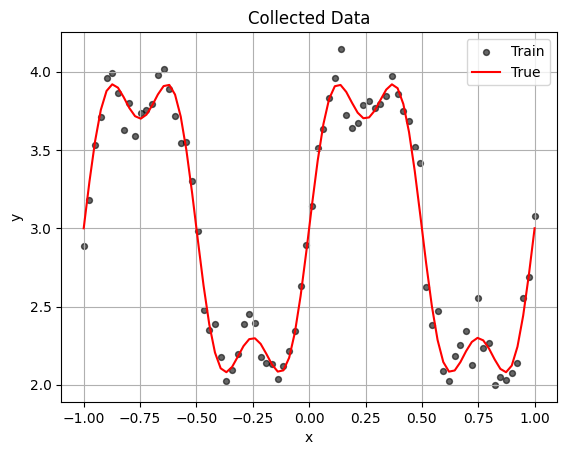

In [ ]:
# =======================
# Collecting DATA
# =======================
import torch, math
import gpytorch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Parameter for data generator
NOISE_STD = 0.1
N = 80

def f(x):
  return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3


# ---------- Data ----------
def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std*torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True)
plt.show()


In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # TODO (Part A): pick a mean; start with ZeroMean (try Constant/Linear in Part C)
        self.mean_module = gpytorch.means.ZeroMean()
        # TODO (Part A): kernel = ScaleKernel(RBFKernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(
           gpytorch.kernels.RBFKernel()
)
        self.covar_module.base_kernel.initialize(lengthscale=0.5)
        self.covar_module.base_kernel.raw_lengthscale.requires_grad = False

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood + model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

iter  200 | loss 0.588 | lengthscale 0.100 | noise 0.0456
iter  400 | loss 0.586 | lengthscale 0.100 | noise 0.0456
iter  600 | loss 0.585 | lengthscale 0.100 | noise 0.0456
iter  800 | loss 0.585 | lengthscale 0.100 | noise 0.0456


/usr/local/lib/python3.12/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


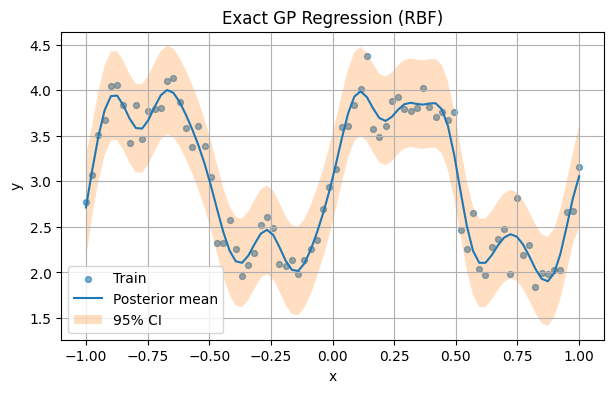

In [ ]:
# ---------- Train (lengthscale=0.1) ----------
training_iter = 800
model.train(); likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.item()
        sn = likelihood.noise.item()
        print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# ---------- Evaluate ----------
model.eval(); likelihood.eval()

# Make test grid on the SAME device as training/model, and as 2D (N,1)
x2 = torch.linspace(-1, 1, N, device=Xtr.device).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.detach().cpu().squeeze()
    lower, upper = pred.confidence_region()
    lower, upper = lower.detach().cpu(), upper.detach().cpu()

x2_cpu   = x2.detach().cpu().squeeze()
Xtr_cpu  = Xtr.detach().cpu().squeeze()
Ytr_cpu  = Ytr.detach().cpu()

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, alpha=0.6, label='Train')
plt.plot(x2_cpu, mean, label='Posterior mean')
plt.fill_between(x2_cpu, lower, upper, alpha=0.25, label='95% CI')
plt.title('Exact GP Regression (RBF)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()



iter  200 | loss 0.355 | lengthscale 0.500 | noise 0.0631
iter  400 | loss 0.333 | lengthscale 0.500 | noise 0.0627
iter  600 | loss 0.325 | lengthscale 0.500 | noise 0.0625
iter  800 | loss 0.321 | lengthscale 0.500 | noise 0.0624


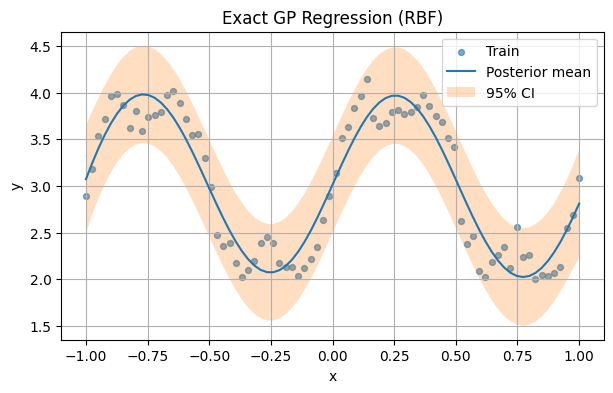

In [ ]:
# ---------- Train (lengthscale=0.5) ----------
training_iter = 800
model.train(); likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.item()
        sn = likelihood.noise.item()
        print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# ---------- Evaluate ----------
model.eval(); likelihood.eval()

# Make test grid on the SAME device as training/model, and as 2D (N,1)
x2 = torch.linspace(-1, 1, N, device=Xtr.device).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.detach().cpu().squeeze()
    lower, upper = pred.confidence_region()
    lower, upper = lower.detach().cpu(), upper.detach().cpu()

x2_cpu   = x2.detach().cpu().squeeze()
Xtr_cpu  = Xtr.detach().cpu().squeeze()
Ytr_cpu  = Ytr.detach().cpu()

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, alpha=0.6, label='Train')
plt.plot(x2_cpu, mean, label='Posterior mean')
plt.fill_between(x2_cpu, lower, upper, alpha=0.25, label='95% CI')
plt.title('Exact GP Regression (RBF)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()



iter  200 | loss 0.251 | lengthscale 0.383 | noise 0.0526
iter  400 | loss 0.246 | lengthscale 0.392 | noise 0.0526
iter  600 | loss 0.245 | lengthscale 0.397 | noise 0.0526
iter  800 | loss 0.244 | lengthscale 0.399 | noise 0.0526
Test MSE on (0.5, 1]: 0.3637


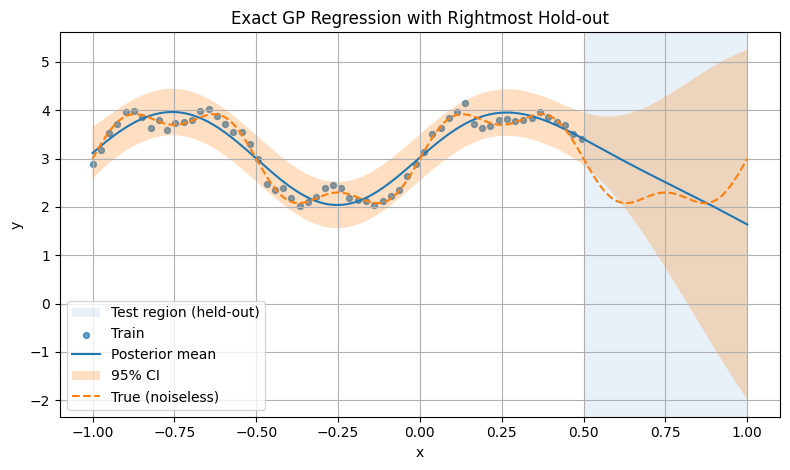

In [ ]:
# =======================
# Imports & setup
# =======================
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# =======================
# Data generator
# =======================
NOISE_STD = 0.1
N = 80  # base grid density for data gen

def f(x):
    # x can be 1D or 2D tensor; ensure math works with torch
    return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3

def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    """
    Returns:
      If holdout_right=False:
        Xtr [n,1], Ytr [n], Xgrid [n,1], Ygrid [n]
      If holdout_right=True:
        Xtr is only the left part (x <= 0.5), Ytr same,
        Xgrid,Ygrid are full grid on [train_range[0], train_range[1]]
    """
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std * torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# =======================
# Exact GP model
# =======================
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module  = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# =======================
# 1) Make split: train on [-1, 0.5], hold out (0.5, 1]
# =======================
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=True)
Xtr, Ytr, Xgrid, Ygrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device), Ygrid.to(device)

# Recreate likelihood + model AFTER making the split (Option A)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

# =======================
# 2) Train (maximize log marginal likelihood)
# =======================
training_iter = 800
model.train(); likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()

    if (i + 1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.detach().cpu().squeeze().item()
        sn = likelihood.noise.detach().cpu().item()
        print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# =======================
# 3) Evaluate on full grid [-1, 1]
# =======================
model.eval(); likelihood.eval()

# Dense grid for smooth curves
x2 = torch.linspace(-1, 1, 400, device=device).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.detach().cpu().squeeze()
    lower, upper = pred.confidence_region()
    lower, upper = lower.detach().cpu(), upper.detach().cpu()

x2_cpu = x2.detach().cpu().squeeze()
f_true = f(x2_cpu)

# Compute simple test MSE on held-out region (0.5, 1]
test_mask = x2_cpu > 0.5
test_mse = float(torch.mean((mean[test_mask] - f_true[test_mask])**2))
print(f"Test MSE on (0.5, 1]: {test_mse:.4f}")

# =======================
# 4) Plot
# =======================
Xtr_cpu = Xtr.detach().cpu().squeeze()
Ytr_cpu = Ytr.detach().cpu()

plt.figure(figsize=(8, 4.8))

# Shade held-out test region
plt.axvspan(0.5, 1.0, alpha=0.10, label='Test region (held-out)')

# Training data
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, alpha=0.7, label='Train')

# Posterior mean & CI
plt.plot(x2_cpu, mean, label='Posterior mean')
plt.fill_between(x2_cpu, lower, upper, alpha=0.25, label='95% CI')

# True function (noiseless)
plt.plot(x2_cpu, f_true, linestyle='--', label='True (noiseless)')

plt.title('Exact GP Regression with Rightmost Hold-out')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(loc='best'); plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# =======================
# Part D: Sparse GP (SVGP)
# =======================
import time
import torch
import gpytorch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Exact GP (from Part A) kept for comparison ---
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module  = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# --- SVGP with inducing points ---
class SVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Variational distribution over inducing function values u=f(Z)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        # Variational strategy ties the variational dist to inducing locations Z
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,  # let Z move during training
        )
        super().__init__(variational_strategy)
        self.mean_module  = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [ ]:
@torch.no_grad()
def predict_posterior(likelihood, model, Xtest):
    model.eval(); likelihood.eval()
    with gpytorch.settings.fast_pred_var():
        pred   = likelihood(model(Xtest))
        mean   = pred.mean.detach().cpu().squeeze()
        lower, upper = pred.confidence_region()
        return mean, lower.detach().cpu().squeeze(), upper.detach().cpu().squeeze()

def train_exact_gp(Xtr, Ytr, iters=500, lr=0.05):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(Xtr, Ytr, likelihood).to(device)
    model.train(); likelihood.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    t0 = time.time()
    for i in range(iters):
        opt.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        opt.step()
    elapsed = time.time() - t0
    return model, likelihood, elapsed

def train_svgp(Xtr, Ytr, M=64, iters=1000, lr=0.05, batch_size=None):
    # Inducing points evenly across the input range
    xmin, xmax = float(Xtr.min()), float(Xtr.max())
    Z = torch.linspace(xmin, xmax, M, device=Xtr.device).unsqueeze(-1)

    model = SVGPModel(Z).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Variational ELBO needs num_data (for minibatching scaling)
    num_data = Xtr.size(0)
    elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_data)

    model.train(); likelihood.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Optional minibatching
    if batch_size is None or batch_size >= num_data:
        # Full-batch variational training
        t0 = time.time()
        for i in range(iters):
            opt.zero_grad()
            out = model(Xtr)
            loss = -elbo(out, Ytr)
            loss.backward()
            opt.step()
        elapsed = time.time() - t0
    else:
        # Mini-batch stochastic variational inference
        perm = torch.randperm(num_data, device=Xtr.device)
        t0 = time.time()
        for i in range(iters):
            # simple cycling mini-batches
            start = (i * batch_size) % num_data
            idx = perm[start:start+batch_size]
            if idx.numel() < batch_size:
                perm = torch.randperm(num_data, device=Xtr.device)
                idx = perm[:batch_size]
            xb, yb = Xtr[idx], Ytr[idx]
            opt.zero_grad()
            out = model(xb)
            loss = -elbo(out, yb)
            loss.backward()
            opt.step()
        elapsed = time.time() - t0

    return model, likelihood, elapsed


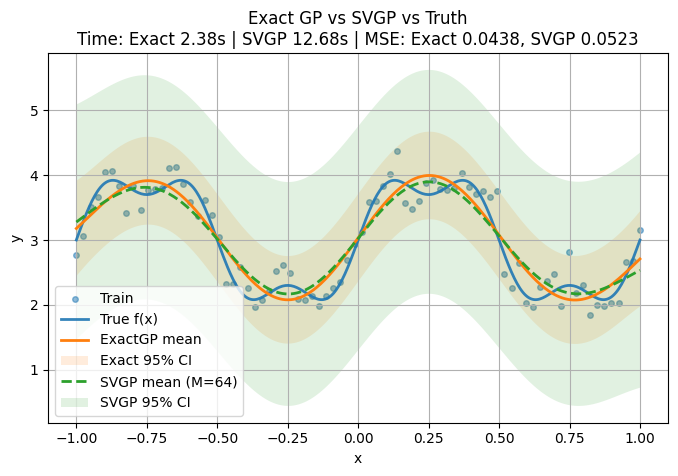

In [ ]:
# ===== Predict =====
ex_mean, ex_lo, ex_hi = predict_posterior(ex_lik, ex_model, Xtest)
sv_mean, sv_lo, sv_hi = predict_posterior(sv_lik, sv_model, Xtest)

# ===== Ground-truth curve on same Xtest =====
with torch.no_grad():
    true_curve = f(Xtest.cpu().squeeze())

# ===== (optional) quick MSEs vs truth =====
import torch.nn.functional as F
mse_exact = F.mse_loss(ex_mean, true_curve).item()
mse_svgp  = F.mse_loss(sv_mean,  true_curve).item()

# ===== Plot comparison (now includes real curve) =====
plt.figure(figsize=(8,4.8))
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=16, alpha=0.5, label='Train')
plt.plot(Xtest.cpu().squeeze(), true_curve, lw=2, label='True f(x)', alpha=0.9)
plt.plot(Xtest.cpu().squeeze(), ex_mean, lw=2, label='ExactGP mean')
plt.fill_between(Xtest.cpu().squeeze(), ex_lo, ex_hi, alpha=0.14, label='Exact 95% CI')
plt.plot(Xtest.cpu().squeeze(), sv_mean, lw=2, ls='--', label='SVGP mean (M=64)')
plt.fill_between(Xtest.cpu().squeeze(), sv_lo, sv_hi, alpha=0.14, label='SVGP 95% CI')
plt.title(
    f'Exact GP vs SVGP vs Truth\n'
    f'Time: Exact {t_exact:.2f}s | SVGP {t_svgp:.2f}s | '
    f'MSE: Exact {mse_exact:.4f}, SVGP {mse_svgp:.4f}'
)
plt.xlabel('x'); plt.ylabel('y'); plt.grid(True); plt.legend()
plt.show()


N=   80 | Exact 1.32s | SVGP(M=32) 7.78s
N=  160 | Exact 1.58s | SVGP(M=32) 7.99s
N=  320 | Exact 1.51s | SVGP(M=32) 8.30s
N=  640 | Exact 1.70s | SVGP(M=32) 8.21s
N= 1280 | Exact 6.48s | SVGP(M=32) 8.24s
N= 2560 | Exact 11.59s | SVGP(M=32) 8.22s


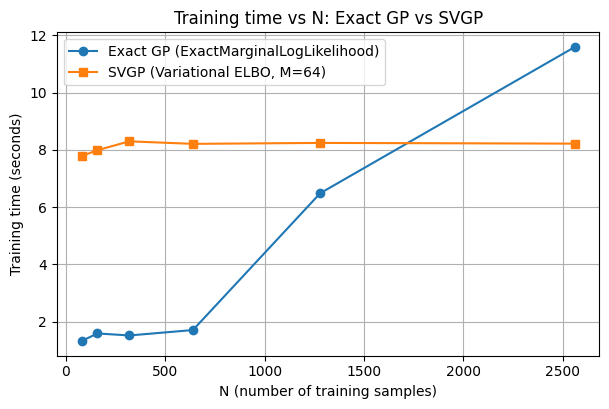

In [ ]:
def benchmark_times(N_list, noise_std=0.2, iters_exact=400, iters_svgp=800, M=64, lr_exact=0.05, lr_svgp=0.03):
    times_exact, times_svgp = [], []
    for N in N_list:
        torch.manual_seed(0)
        Xtr, Ytr, _, _ = make_data(n=N, noise_std=noise_std, holdout_right=False)
        Xtr, Ytr = Xtr.to(device), Ytr.to(device)

        # Exact GP
        _, _, tE = train_exact_gp(Xtr, Ytr, iters=iters_exact, lr=lr_exact)
        times_exact.append(tE)

        # SVGP (full-batch; set batch_size to, e.g., 256 for large N)
        batch_size = None if N <= 2000 else 256
        _, _, tS = train_svgp(Xtr, Ytr, M=M, iters=iters_svgp, lr=lr_svgp, batch_size=batch_size)
        times_svgp.append(tS)

        print(f"N={N:5d} | Exact {tE:.2f}s | SVGP(M={M}) {tS:.2f}s")

    return times_exact, times_svgp

# Run the benchmark
N_list = [80, 160, 320, 640, 1280, 2560]
tE, tS = benchmark_times(N_list, iters_exact=400, iters_svgp=800, M=32)

# Plot training time vs N
plt.figure(figsize=(7,4.2))
plt.plot(N_list, tE, marker='o', label='Exact GP (ExactMarginalLogLikelihood)')
plt.plot(N_list, tS, marker='s', label='SVGP (Variational ELBO, M=64)')
plt.xlabel('N (number of training samples)')
plt.ylabel('Training time (seconds)')
plt.title('Training time vs N: Exact GP vs SVGP')
plt.grid(True); plt.legend()
plt.show()


## Exercise 2 (Optional, except PhD students): Model-Based Reinforcement Learning with Gaussian Process + MPC
***Goal:***
Learn the core ideas of **Model-Based Reinforcement Learning (MBRL)** by:
- Learning a **dynamics model** with a Gaussian Process (GP)
- Using **Model Predictive Control (MPC)** to plan actions
- Comparing against random or fixed policies

We’ll use a simplified version of **GP-MPC** (similar in spirit to PILCO or PETS) on the *MountainCarContinuous-v0* task.

---

## 1 Background
The system dynamics are unknown.  
We collect transitions
\[
(x_t, u_t, r_t, x_{t+1})
\]
and learn a GP model of the change in state:
\[
\Delta x = f(x_t, u_t) + \varepsilon
\]
Then, given a current state, we **simulate** future trajectories using the GP mean prediction and pick an action sequence that maximizes the expected reward (or minimizes cost) over a short horizon — the **MPC** loop.

---

## 2 Steps

### Part A — Collect data with a random policy
1. Run `N = 1000` random actions.
2. Store transitions \((x_t, u_t, x_{t+1})\).
3. Compute state differences:  
   `dx = x_next - x`.

### Part B — Train a Gaussian Process model
1. Fit a GP for each state dimension (here 2: position and velocity).  
   Inputs = `[x_t, u_t]`  
   Outputs = `dx_t`
2. Use **GPyTorch** or **sklearn.gaussian_process**.
3. Plot model predictions vs. ground truth for a few samples.

### Part C — Implement a simple MPC controller
1. At each step:
   - Start from current state \(x_t\).
   - Sample \(K\) random control sequences of horizon \(H\).
   - For each sequence, **simulate forward** using GP predictions.
   - Compute cumulative reward (from MountainCarContinuous env).
   - Execute the *first action* of the best sequence.
2. Repeat until termination or max steps.

### Part D — Evaluate and visualize
1. Plot the car’s trajectory (position vs. time).
2. Compare with random policy performance.
3. Discuss:  
   - How does the GP model’s accuracy affect control?  
   - How many random samples or planning horizon are needed?

---

## Deliverables
- Code for data collection, GP training, and MPC loop.
- Plots:
  - GP predictions vs. true next states.
  - Car’s position vs. time during control.
- Short discussion (≈½ page):
  - How did planning horizon affect performance?
  - How does GP uncertainty limit long-term planning?

---

## Optional extensions
- Add GP uncertainty penalty in cost function.
- Try a learned NN model instead of GP.
- Use warm-start data from a heuristic controller.
- Compare Exact GP vs. Sparse GP (SVGP).

---

## Hints
- Normalize inputs and outputs before GP training.
- Use a small horizon (H≈15–20) for efficiency.
- Reward function from environment:
  ```python
  reward = 100 * (abs(x) >= 0.45) - 0.1 * u**2

## Exercise 3: Getting Started with MuJoCo and XML Models
***Goal:***
The goal of this exercise is to **install MuJoCo**, explore its **Python interface**, and learn the structure of **MJCF (XML) models** used to describe robots and environments.  
By the end, you should be able to:
- Run a MuJoCo simulation locally  
- Open, modify, and reload a simple XML model  
- Use Google Colab connected to your local runtime

---

MuJoCo (“Multi-Joint dynamics with Contact”) is a fast physics engine widely used in robotics and reinforcement learning.  
It uses XML (MJCF files) to describe bodies, joints, sensors, and actuators.

In this exercise, you will:
1. Install MuJoCo on your computer  
2. Install and run Jupyter Notebook or Lab  
3. Connect Colab to your local runtime  
4. Run Mujco with existent XML (car, quadrotor, mountain)
6. Create a scene with multiple falling objects

---
## Step-by-Step Instructions
### 1 Install MuJoCo: Download and install
- Visit [https://mujoco.org/download](https://mujoco.org/download)  
- Choose the installer for your OS (Windows, macOS, or Linux)

### 2 Install Jupyter

You can use either JupyterLab or Jupyter Notebook

```
pip install jupyterlab
```

Run
```
jupyter lab
```
This should open your browser at:
```
http://localhost:8888/lab
```

### 3 Configure Google Colab to Run Locally

### 4 Run a Simple MuJoCo Simulation


In [1]:
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3
!pip install mujoco mujoco-python-viewer


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libosmesa6 libpciaccess-dev mesa-common-dev
Suggested packages:
  libgles1 libvulkan1
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglfw3 libglx-dev libosmesa6 libosmesa6-dev
  libpciaccess-dev mesa-common-dev
0 upgraded, 8 newly installed, 0 to remove and 38 not upgraded.
Need to get 5,844 kB of archives.
After this operation, 18.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.com/ubunt

In [2]:
import mujoco
from mujoco import MjModel, MjData
print("MuJoCo version:", mujoco.__version__)



MuJoCo version: 3.3.7


In [3]:
xml = """
<mujoco model="falling_ball">
  <option timestep="0.002"/>
  <worldbody>
    <geom name="floor" type="plane" pos="0 0 0" size="3 3 0.1" rgba="0.8 0.8 0.8 1"/>
    <body name="ball" pos="0 0 1.5">
      <freejoint/>
      <geom type="sphere" size="0.08" rgba="0.2 0.5 0.9 1"/>
    </body>
  </worldbody>
</mujoco>
"""

model = MjModel.from_xml_string(xml)
data = MjData(model)

# Simulate for 1000 steps
for i in range(1000):
    mujoco.mj_step(model, data)

print("Final qpos:", data.qpos)
print("Final qvel:", data.qvel)
print("Simulation done ✅")


Final qpos: [0.         0.         0.07963282 1.         0.         0.
 0.        ]
Final qvel: [ 0.00000000e+00  0.00000000e+00 -9.53989107e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Simulation done ✅


In [ ]:
# --- System deps + env for headless OpenGL ---
!apt-get -qq install -y libosmesa6-dev libgl1-mesa-dev libgl1-mesa-glx > /dev/null

# IMPORTANT: set backend BEFORE importing mujoco
import os
os.environ["MUJOCO_GL"] = "osmesa"   # or "egl" if you prefer EGL and have proper drivers

# --- Now import and run your simulation ---
import mujoco
import numpy as np
import matplotlib.pyplot as plt

# Minimal XML (define `xml` since your snippet expects it)
xml = """
<mujoco model="falling_box">
  <option timestep="0.002"/>
  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <geom type="plane" size="1 1 0.1" rgba=".9 0 0 1"/>
    <body pos="0 0 1">
      <freejoint/>
      <geom type="box" size=".1 .2 .3" rgba="0 .9 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
data  = mujoco.MjData(model)

# Offscreen renderer (square frame)
renderer = mujoco.Renderer(model, 480, 480)

frames = []
for i in range(100):
    mujoco.mj_step(model, data)
    renderer.update_scene(data)
    pixels = renderer.render()
    if i % 10 == 0:
        frames.append(pixels)

plt.imshow(frames[-1])
plt.axis("off")
plt.title("Last Frame — Falling Box")
plt.show()


# Test with the following XMLs

In [ ]:
# CAR
XML = r"""
<mujoco model="simple_car_gazebo_style">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.12"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="40 40"
              specular="0.05" shininess="0.3" reflectance="0.2" rgba="1 1 1 1"/>
    <material name="chassis_mat" rgba="0.12 0.30 0.75 1" specular="0.2" shininess="0.4"/>
    <material name="tire_mat"    rgba="0.07 0.07 0.07 1" specular="0.05" shininess="0.2"/>
  </asset>

  <default>
    <!-- No default rgba here; let materials show through -->
    <geom contype="1" conaffinity="1" friction="1.0 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun_dir" directional="true" castshadow="true"
           pos="0 0 5" dir="0.2 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="0 0 3" dir="-0.3 -0.2 -1" diffuse="0.3 0.3 0.35" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <geom name="floor" type="plane" pos="0 0 0" size="20 20 0.1" material="ground_mat"/>

    <!-- Chassis center at z=0.22 = wheel_radius(0.10)+half_chassis(0.10)+clearance(0.02) -->
    <body name="chassis" pos="0 0 0.22">
      <freejoint name="chassis_free"/>
      <geom name="chassis_box" type="box" size="0.40 0.25 0.10" material="chassis_mat"/>

      <!-- Wheel radius=0.10; centers should be at absolute z=0.10.
           Relative z offset = 0.10 - 0.22 = -0.12 (below chassis center). -->
      <!-- Cylinder axis along y: rotate +90deg about x -->
      <body name="wheel_fl" pos=" 0.35  0.22 -0.12">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_fr" pos=" 0.35 -0.22 -0.12">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rl" pos="-0.35  0.22 -0.12">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rr" pos="-0.35 -0.22 -0.12">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="m_fl" joint="j_fl" gear="120"/>
    <motor name="m_fr" joint="j_fr" gear="120"/>
    <motor name="m_rl" joint="j_rl" gear="120"/>
    <motor name="m_rr" joint="j_rr" gear="120"/>
  </actuator>
</mujoco>



"""

In [ ]:
## Drone
XML = r"""
<mujoco model="quad2d">
  <option gravity="0 0 -9.81" timestep="0.005"/>
  <worldbody>
    <body name="quad" pos="0 0 1">
      <!-- 2D DOF -->
      <joint name="x"     type="slide" axis="1 0 0" limited="false"/>
      <joint name="z"     type="slide" axis="0 0 1" limited="false"/>
      <joint name="pitch" type="hinge" axis="0 1 0" limited="false"/>

      <!-- frame -->
      <geom type="box" size="0.15 0.02 0.01" rgba="0.2 0.5 0.8 1"/>

      <!-- thruster sites (±arm) -->
      <site name="left"  pos="-0.15 0 0" size="0.01" rgba="1 0 0 1"/>
      <site name="right" pos="+0.15 0 0" size="0.01" rgba="0 1 0 1"/>

      <!-- mass/inertia (defaults are fine for demo) -->
      <inertial pos="0 0 0" mass="0.6" diaginertia="0.002 0.002 0.004"/>
    </body>

    <!-- ground plane -->
    <geom name="ground" type="plane" pos="0 0 0" size="5 5 0.1" rgba="0.8 0.8 0.8 1"/>
  </worldbody>

<actuator>
  <!-- Control u in [0, 20]; actual applied force = gainprm[0] * u along gear direction -->
  <general name="thrust_left"  site="left"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>

  <general name="thrust_right" site="right"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>
</actuator>


  <sensor>
    <framepos    name="pos"  objtype="body" objname="quad"/>
    <frameangvel name="omega" objtype="body" objname="quad"/>
    <framelinvel name="vlin"  objtype="body" objname="quad"/>
  </sensor>
</mujoco>
"""

In [ ]:
# Mountain

XML = r"""
<mujoco model="car_on_piecewise_curved_ramp">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.10"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="12 2"
              specular="0.05" shininess="0.3" reflectance="0.08" rgba="1 1 1 1"/>

    <!-- Car materials -->
    <material name="paint" rgba="0.10 0.22 0.70 1" specular="0.45" shininess="0.7" reflectance="0.10"/>
    <material name="glass" rgba="0.20 0.28 0.35 0.35" specular="0.6" shininess="0.8" reflectance="0.1"/>
    <material name="tire"  rgba="0.06 0.06 0.06 1" specular="0.05" shininess="0.2"/>
    <material name="rim"   rgba="0.85 0.85 0.88 1" specular="0.6" shininess="0.8"/>
    <material name="black" rgba="0.04 0.04 0.05 1" specular="0.1" shininess="0.2"/>
  </asset>

  <default>
    <geom contype="1" conaffinity="1" friction="1.3 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun" directional="true" castshadow="true"
           pos="0 0 8" dir="0.25 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="-2 -2 4" dir="0.3 0.1 -1" diffuse="0.35 0.35 0.4" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <camera name="valley_view" mode="fixed" pos="-3.2 -1.2 1.3" euler="0.12 0.42 0.8" fovy="45"/>

    <!-- ========= Piecewise-curved ramp (sign-corrected pitches) =========
         z(x) = 0.15 x^2  ->  dz/dx = 0.30 x  ->  pitch θy = -atan(0.30 x)
         Centers at x = [-2.25, -1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75, 2.25]
    -->
    <geom name="seg_m2_25" type="box" size="0.25 1.0 0.02" pos="-2.25 0 0.759" euler="0  0.595 0" material="ground_mat"/>
    <geom name="seg_m1_75" type="box" size="0.25 1.0 0.02" pos="-1.75 0 0.459" euler="0  0.487 0" material="ground_mat"/>
    <geom name="seg_m1_25" type="box" size="0.25 1.0 0.02" pos="-1.25 0 0.234" euler="0  0.358 0" material="ground_mat"/>
    <geom name="seg_m0_75" type="box" size="0.25 1.0 0.02" pos="-0.75 0 0.084" euler="0  0.221 0" material="ground_mat"/>
    <geom name="seg_m0_25" type="box" size="0.25 1.0 0.02" pos="-0.25 0 0.009" euler="0  0.075 0" material="ground_mat"/>
    <geom name="seg_0"     type="box" size="0.25 1.0 0.02" pos=" 0.00 0 0.000" euler="0  0.000 0" material="ground_mat"/>
    <geom name="seg_p0_25" type="box" size="0.25 1.0 0.02" pos=" 0.25 0 0.009" euler="0 -0.075 0" material="ground_mat"/>
    <geom name="seg_p0_75" type="box" size="0.25 1.0 0.02" pos=" 0.75 0 0.084" euler="0 -0.221 0" material="ground_mat"/>
    <geom name="seg_p1_25" type="box" size="0.25 1.0 0.02" pos=" 1.25 0 0.234" euler="0 -0.358 0" material="ground_mat"/>
    <geom name="seg_p1_75" type="box" size="0.25 1.0 0.02" pos=" 1.75 0 0.459" euler="0 -0.487 0" material="ground_mat"/>
    <geom name="seg_p2_25" type="box" size="0.25 1.0 0.02" pos=" 2.25 0 0.759" euler="0 -0.595 0" material="ground_mat"/>
    <geom name="ground"    type="plane" pos="0 0 -0.02" size="10 10 0.1" material="ground_mat"/>

        <!-- Translucent narrow walls to keep the car aligned -->
    <geom name="left_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0  0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>

    <geom name="right_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0 -0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>



    <!-- ===== Car (same spec as before, slightly smaller) ===== -->
    <body name="chassis" pos="-1.5 0 0.70">
      <freejoint/>
      <geom type="box"       size="0.24 0.15 0.06" material="paint"/>
      <geom type="ellipsoid" size="0.15 0.12 0.06" pos="0.03 0 0.07" material="glass"/>
      <geom type="box"       size="0.05 0.15 0.02" pos="-0.30 0 -0.03" material="black"/>

      <!-- Wheels: radius=0.05, axle along local y -->
      <body name="wheel_fl" pos=" 0.20  0.13 -0.085">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_fr" pos=" 0.20 -0.13 -0.085">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rl" pos="-0.19  0.13 -0.085">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rr" pos="-0.19 -0.13 -0.085">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="j_fl" gear="120"/>
    <motor joint="j_fr" gear="120"/>
    <motor joint="j_rl" gear="120"/>
    <motor joint="j_rr" gear="120"/>
  </actuator>
</mujoco>


"""

## Create a Scene with Falling Objects

Now let’s create a small **physics scene** to understand how MuJoCo handles **contacts and collisions**.

You’ll build an XML with **two cubes and one sphere**, stacked vertically so that they fall and collide naturally under gravity.

Add a screenshot in a cell of the notebook.

In [13]:
from google.colab import files
files.download("/content/stack_demo_egl_fixed.gif")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

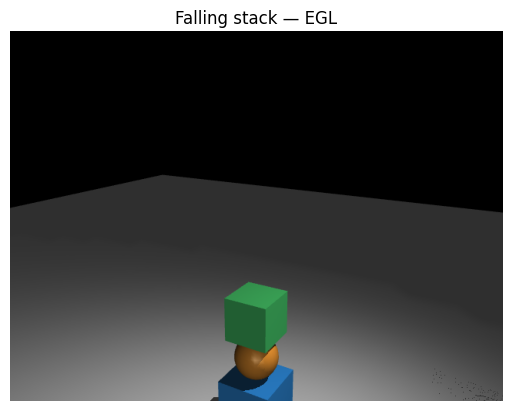

Saved MP4: /content/stack_fall.mp4


In [17]:
# --- Setup: use EGL backend on a GPU runtime ---
!apt-get -qq install -y libegl1 libgles2-mesa-dev > /dev/null

import os
os.environ["MUJOCO_GL"] = "egl"   # GPU offscreen

import mujoco
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
from IPython.display import Video

XML = r"""
<mujoco model="stack_two_cubes_one_sphere">
  <compiler inertiafromgeom="true"/>
  <option timestep="0.002" gravity="0 0 -9.81"/>
  <default>
    <geom density="1000" friction="0.8 0.1 0.1"/>
  </default>

  <worldbody>
    <geom name="floor" type="plane" pos="0 0 0" size="6 6 0.1" rgba="0.9 0.9 0.9 1"/>

    <!-- Start everything much higher to see the fall clearly -->
    <body name="cube_bottom" pos="0 0 1.00">
      <freejoint/>
      <geom type="box" size="0.15 0.15 0.15" rgba="0.20 0.60 0.95 1"/>
    </body>

    <body name="sphere_mid" pos="0 0 1.50">
      <freejoint/>
      <geom type="sphere" size="0.12" rgba="0.95 0.60 0.20 1"/>
    </body>

    <body name="cube_top" pos="0 0 1.90">
      <freejoint/>
      <geom type="box" size="0.12 0.12 0.12" rgba="0.30 0.85 0.45 1"/>
    </body>

    <light diffuse=".7 .7 .7" pos="1.5 1.0 3.0" dir="-1 -1 -2"/>
  </worldbody>
</mujoco>
"""

# Build model/data
model = mujoco.MjModel.from_xml_string(XML)
data  = mujoco.MjData(model)

# Manual camera
cam = mujoco.MjvCamera(); mujoco.mjv_defaultCamera(cam)
cam.lookat[:]  = np.array([0.0, 0.0, 1.2])  # look higher
cam.distance   = 2.2
cam.azimuth    = 120.0
cam.elevation  = -15.0

# Sim params
sim_time = 6.0      # seconds
fps = 30
next_frame_t = 0.0

frames = []

# Use context manager so renderer closes cleanly (no __del__ warning)
with mujoco.Renderer(model, height=480, width=640) as renderer:
    while data.time < sim_time:
        while data.time < next_frame_t:
            mujoco.mj_step(model, data)
        renderer.update_scene(data, camera=cam)
        frames.append(renderer.render().copy())
        next_frame_t += 1.0 / fps

# Show last frame
plt.imshow(frames[-1]); plt.axis("off"); plt.title("Falling stack — EGL"); plt.show()

# Save smooth MP4 (no GIF flicker)
mp4_path = "/content/stack_fall.mp4"
iio.imwrite(mp4_path, frames, fps=fps, codec="libx264", quality=8)
print(f"Saved MP4: {mp4_path}")
Video(mp4_path, embed=True)
# To download:
# from google.colab import files; files.download(mp4_path)
